In [18]:
!pip3 install lightgbm

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

In [2]:
train_data = pd.read_csv('./train.csv', index_col = 'Id')
test_data = pd.read_csv('./test.csv', index_col = 'Id')

print(train_data.shape)
train_data.groupby('Functional').count()
# tmp = train_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]]
# tmp.corr().abs()
# plt.figure(figsize=(100, 100))
# sb.heatmap(tmp.corr().abs(),  annot=True)
# plt.show()

(1460, 77)


MSSubClass  LotFrontage  LotArea  Street  LotShape  LandContour  \
Functional                                                                    
Maj1                14           12       14      14        14           14   
Maj2                 5            5        5       5         5            5   
Min1                31           24       31      31        31           31   
Min2                34           28       34      34        34           34   
Mod                 15           14       15      15        15           15   
Sev                  1            0        1       1         1            1   
Typ               1360         1118     1360    1360      1360         1360   

            Utilities  LotConfig  LandSlope  Neighborhood  ...  ScreenPorch  \
Functional                                                 ...                
Maj1               14         14         14            14  ...           14   
Maj2                5          5          5             5  ...            5   
Min1               31         31         31            31  ...           31   
Min2               34         34         34            34  ...           34   
Mod                15         15         15            15  ...           15   
Sev                 1          1          1             1  ...            1   
Typ              1360       1360       1360          1360  ...         1360   

            PoolArea  PoolQC  Fence  MiscVal  MoSold  YrSold  SaleType  \
Functional                                                               
Maj1              14       0      4       14      14      14        14   
Maj2               5       0      0        5       5       5         5   
Min1              31       0     16       31      31      31        31   
Min2              34       0      8       34      34      34        34   
Mod               15       0      3       15      15      15        15   
Sev                1       0      0        1       1       1         1   
Typ             1360       7    250     1360    1360    1360      1360   

            SaleCondition  SalePrice  
Functional                            
Maj1                   14         14  
Maj2                    5          5  
Min1                   31         31  
Min2                   34         34  
Mod                    15         15  
Sev                     1          1  
Typ                  1360       1360  

[7 rows x 76 columns]

# Plan
1. empty values/NaNs  - we can think about imputation or smarter way to drop samples
2. check for outliers
3. see distributions for features
4. remove features that has small variability   - 
5. mapping classes into numeric values
6. look into feature correlation

**1**

In [3]:
#train_data
def factorize_categorical(df):
    df_copy = df.copy() 
    mapping_map = {
        "LotShape": {"Reg":1, "IR1":2/3 , "IR2":1/3, "IR3":0},
        "LandContour": {"Lvl":1 , "Bnk":2/3 , "HLS":1/3, "Low":0},
        "LotConfig": {"Inside":1, "Corner":0.75, "CulDSac":0.5, "FR2":0.25, "FR3":0},
        "LandSlope": {"Gtl":1, "Mod":0.5,  "Sev":0},
        "BldgType": {"1Fam":1, "2FmCon":0.75, "Duplx":0.5, "TwnhsE":0.25, "TwnhsI":0},
        "ExterQual": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "ExterCond": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "BsmtQual": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "BsmtCond": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "BsmtExposure": {"Gd":1, "Av":0.75, "Mn":0.5, "No":0.25, "NA":0},
        "BsmtFinType1": {"GLQ":1, "ALQ":5/6, "BLQ":4/6, "Rec":3/6, "LwQ":2/6, "Unf":1/6, "NA":0},
        "BsmtFinType2": {"GLQ":1, "ALQ":5/6, "BLQ":4/6, "Rec":3/6, "LwQ":2/6, "Unf":1/6, "NA":0},
        "HeatingQC": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "KitchenQual": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "Functional": {"Typ":1, "Min1":6/7, "Min2":5/7, "Mod":4/7, "Maj1":3/7, "Maj2":2/7, "Sev":1/7, "Sal":0},
        "FireplaceQu": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "GarageFinish": {"Fin":1, "RFn":2/3, "Unf": 1/3, "NA":0},
        "GarageQual": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "GarageCond": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "PavedDrive": {"Y":1, "P":0.5, "N":0},
        "PoolQC": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "Fence": {"GdPrv":1, "MnPrv":0.75, "GdWo":0.5, "MnWw":0.25, "NA":0},
        "SaleCondition": {"Normal":1, "Abnorml":0.75, "Alloca":0.5, "Family":0.25, "Partial":0}
    }
    
    for key, value in mapping_map.items():
        df_copy[key] = df_copy[key].map(value)
        
    return df_copy

In [4]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_rid_of_high_related_columns(df):
    print("Shape before cleaning:", df.shape[1])
    df_copy = df.copy()
    high_impact_on_price = []

    columns_to_drop = []
    
    top_abs = get_top_abs_correlations(df_copy)

    for ind in top_abs.index:
        if 'SalePrice' in ind:
            high_impact_on_price.append(ind[0])

    for i, k in zip(top_abs.index, top_abs):
        if (i[0] in high_impact_on_price) or (i[1] in high_impact_on_price):
            continue

        if k > 0.75:
            columns_to_drop.append(i[0])
    
    df = df.drop(columns = columns_to_drop)
    
    return df, columns_to_drop, high_impact_on_price

def fill_na_with_meaning(df):
    columns_with_na = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond" , "PoolQC", "Fence"]
    for col in columns_with_na:
        df[col] = df[col].fillna(0)
    return df

def clean_garages(df):
    # Amount of NaN values in the remaining object columns
    # 'Exterior1st' - 1
    # 'Exterior2nd' - 1 
    # 'SaleType' - 1
    # 'Utilities' - 2
    # 'MasVnrType' - 16
    # 'GarageType' - 76
    
    # We found that GarageType is biggest source of NaNs in test set,
    # so we decided to clean it up manually by looking up in already factorized colums 
    # that relates to GarageType - GarageCond/GarageQlt
    df['GarageType'] = df['GarageType'].fillna(0)
    return df

def factorization_mapping(df):
    train_factor_mapping = {}

    # For columns that are still of type object we are factorizing
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col], uniques = pd.factorize(df[col], sort = True)
            train_factor_mapping[col] = dict(zip(uniques.to_list(), range(len(uniques))))
            
    return df, train_factor_mapping

def apply_factor_map_to_test(df, factor_map):
    for col in factor_map:
        df[col] = df[col].map(factor_map[col])
        df[col] = df[col].fillna(-1)

    return df

def categories_to_dummies(df, factor_map):
    for col in factor_map:
        if len(factor_map[col])>2:
            print("column to dummies-", col)
            dummies = pd.get_dummies(df[col])
            df = df.drop(columns=[col])
            df = pd.concat([df, dummies], axis=1)
    return df

def remove_outliers(df, z_score = 5):
    print(df.shape, "before zscore")
    # remove outliers by there Z-score (example" LotArea column)
    # The recommended threshold is 3, but it cuased a big number of drops so I increased it to 5 
    df = df[(np.abs(zscore(df)) < z_score).all(axis=1)]
    print(df.shape, "after zscore")
    
    return df

def low_variance_columns(df, percentage = 0.99):
    # detect columns with high precantage from one value
    low_variance_col = []
    
    for col in df.columns:
        count= df[col].value_counts(normalize=True).values
        if sum(count>percentage):
            low_variance_col.append(col)
    
    df = df.drop(columns = low_variance_col)
    
    return df, low_variance_col

def apply_low_variance_to_test(df, low_variance_col):
    df = df.drop(columns = low_variance_col)
    return df

def clean_train(df):
    df = df.copy()

    # Columns where NaN means that something doesn't exists rather that it's an empty data or unknown
    df = fill_na_with_meaning(df)
    
    # Map categorical values where categories represent weights
    df = factorize_categorical(df)
    
    df = clean_garages(df)
    
    # NOTA BENE: only for train set
    df, factor_map = factorization_mapping(df)
    
    # fillna with mean col value
    df = df.fillna(df.mean())
    
    # NOTA BENE: only for train set
    df = remove_outliers(df)
    
    # NOTA BENE: only for train set
    df, low_variance_col = low_variance_columns(df)
    
    # NOTA BENE: only for train set
    df, columns_to_drop, high_corr_with_price = get_rid_of_high_related_columns(df)
    
    return df, factor_map, low_variance_col, columns_to_drop, high_corr_with_price

def clean_test(df, factor_map, low_variance_col, columns_to_drop):    
    df = df.copy()

    # Columns where NaN means that something doesn't exists rather that it's an empty data or unknown
    df = fill_na_with_meaning(df)
    
    # Map categorical values where categories represent weights
    df = factorize_categorical(df)
    
    df = clean_garages(df)
    
    # NOTA BENE: only for test set
    df = apply_factor_map_to_test(df, factor_map)
    
    # fillna with mean col value
    df = df.fillna(df.mean())
    
    # NOTA BENE: only for test set
    df = apply_low_variance_to_test(df, low_variance_col)
    
    # NOTA BENE: only for test set
    df = df.drop(columns = columns_to_drop)
    
    return df


In [5]:
def data_dist(df):
    n_col = 6
    n_row = np.ceil(df.shape[1]/n_col)
    fig = plt.figure(figsize=(3 * n_col, 2.4 * n_row))  
    for i, col in enumerate(df.columns):
        plt.subplot(n_row, n_col, i + 1)
        n, bins, patches= plt.hist(df[col], density=True)
        plt.title(col, y=1.03)
    fig.tight_layout(pad=2)

(1460, 77) before zscore
(1280, 77) after zscore
Shape before cleaning: 69
Trainining data distribution


<ipython-input-5-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


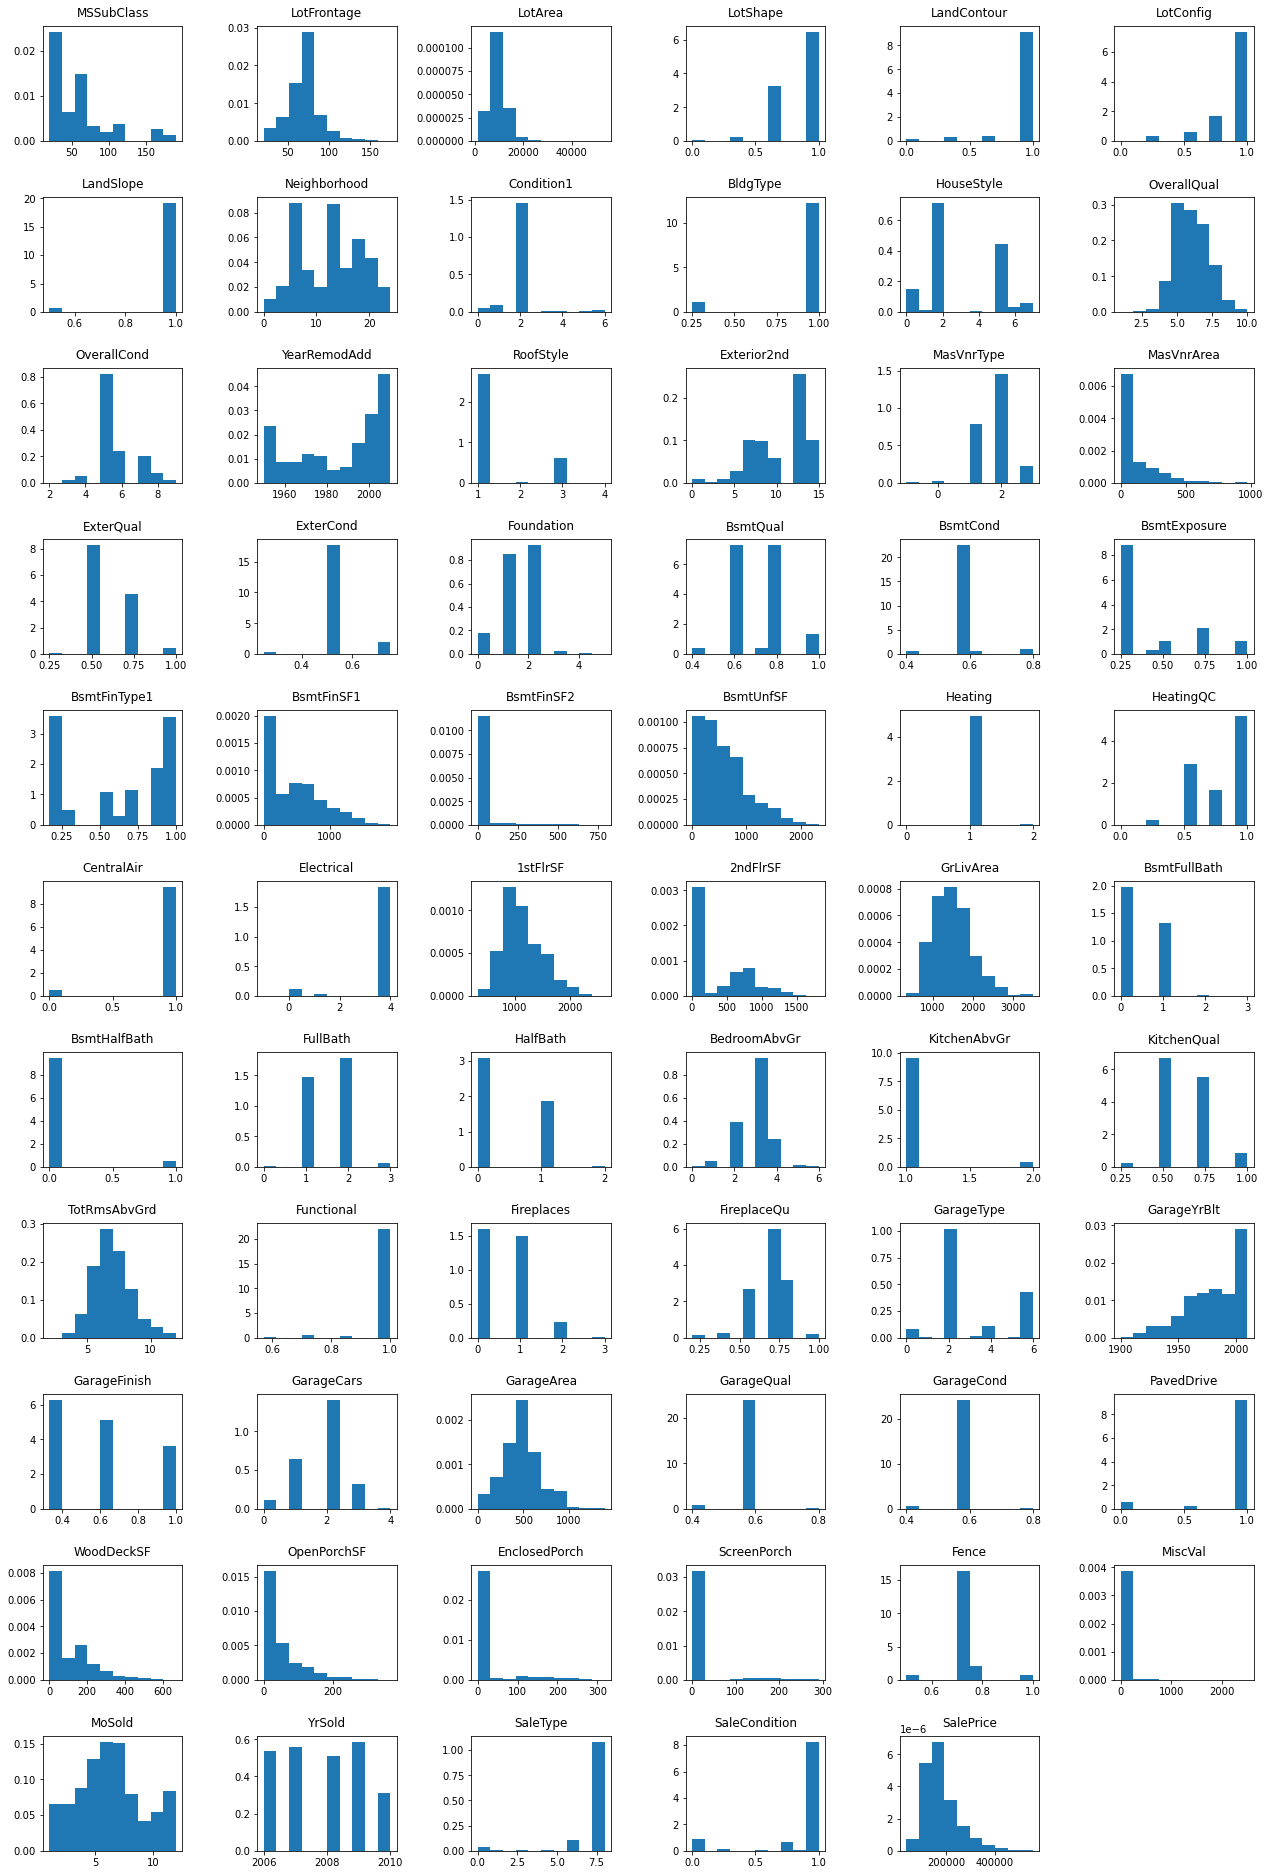

In [6]:
train, factor_map, low_variance_col, columns_to_drop, high_corr_with_price = clean_train(train_data)
print("Trainining data distribution")
data_dist(train)

# one issue we didnt handle is to transfer all categoriacl columns into dummies. we should do it based on 
#  "factor_map" and better to do that at the end of the process. 
# I wrote a function that is doinf that - categories_to_dummies- but it will be better to consider in 
# here that "Condition1" + "Condition2" & "Exterior1st" + "Exterior2nd" will get dummies together
# **there mapping dict is different so I wasnt sure how to do that

# column to dummies- Condition1  #can be together with next one
# column to dummies- Condition2

# column to dummies- Exterior1st  #can be together with next one
# column to dummies- Exterior2nd


OverallQual


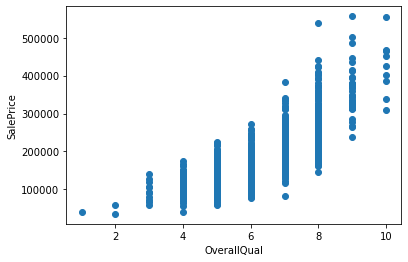

GrLivArea


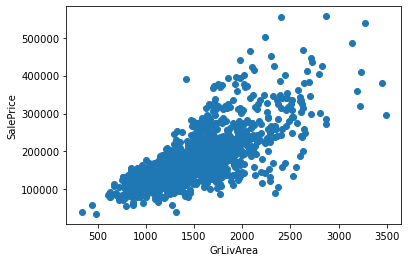

ExterQual


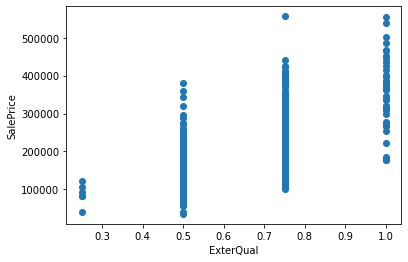

KitchenQual


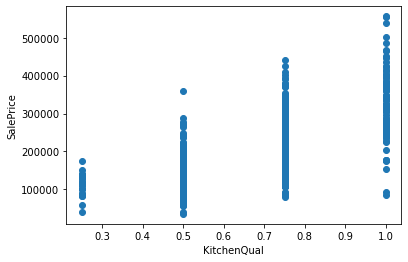

GarageCars


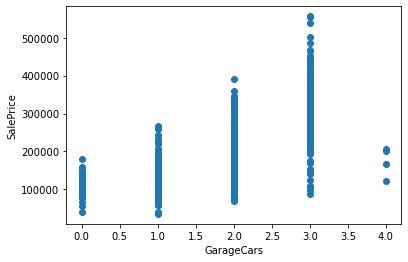

In [7]:
for col in high_corr_with_price:
    print(col)
    plt.scatter(train[col], train.SalePrice)
    plt.ylabel("SalePrice")
    plt.xlabel(col)
    plt.show()

In [8]:
train.head()

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60         65.0     8450  1.000000          1.0       1.00   
2           20         80.0     9600  1.000000          1.0       0.25   
3           60         68.0    11250  0.666667          1.0       1.00   
4           70         60.0     9550  0.666667          1.0       0.75   
5           60         84.0    14260  0.666667          1.0       0.25   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2       1.0  ...           61   
2         1.0            24           1       1.0  ...            0   
3         1.0             5           2       1.0  ...           42   
4         1.0             6           2       1.0  ...           35   
5         1.0            15           2       1.0  ...           84   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   

    SaleCondition  SalePrice  
Id                            
1            1.00     208500  
2            1.00     181500  
3            1.00     223500  
4            0.75     140000  
5            1.00     250000  

[5 rows x 65 columns]

In [9]:
plt.figure(figsize=(200, 200), dpi=100)
sb.heatmap(train.corr().abs(),  annot=True)
plt.show()

Test data distribution


<ipython-input-5-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


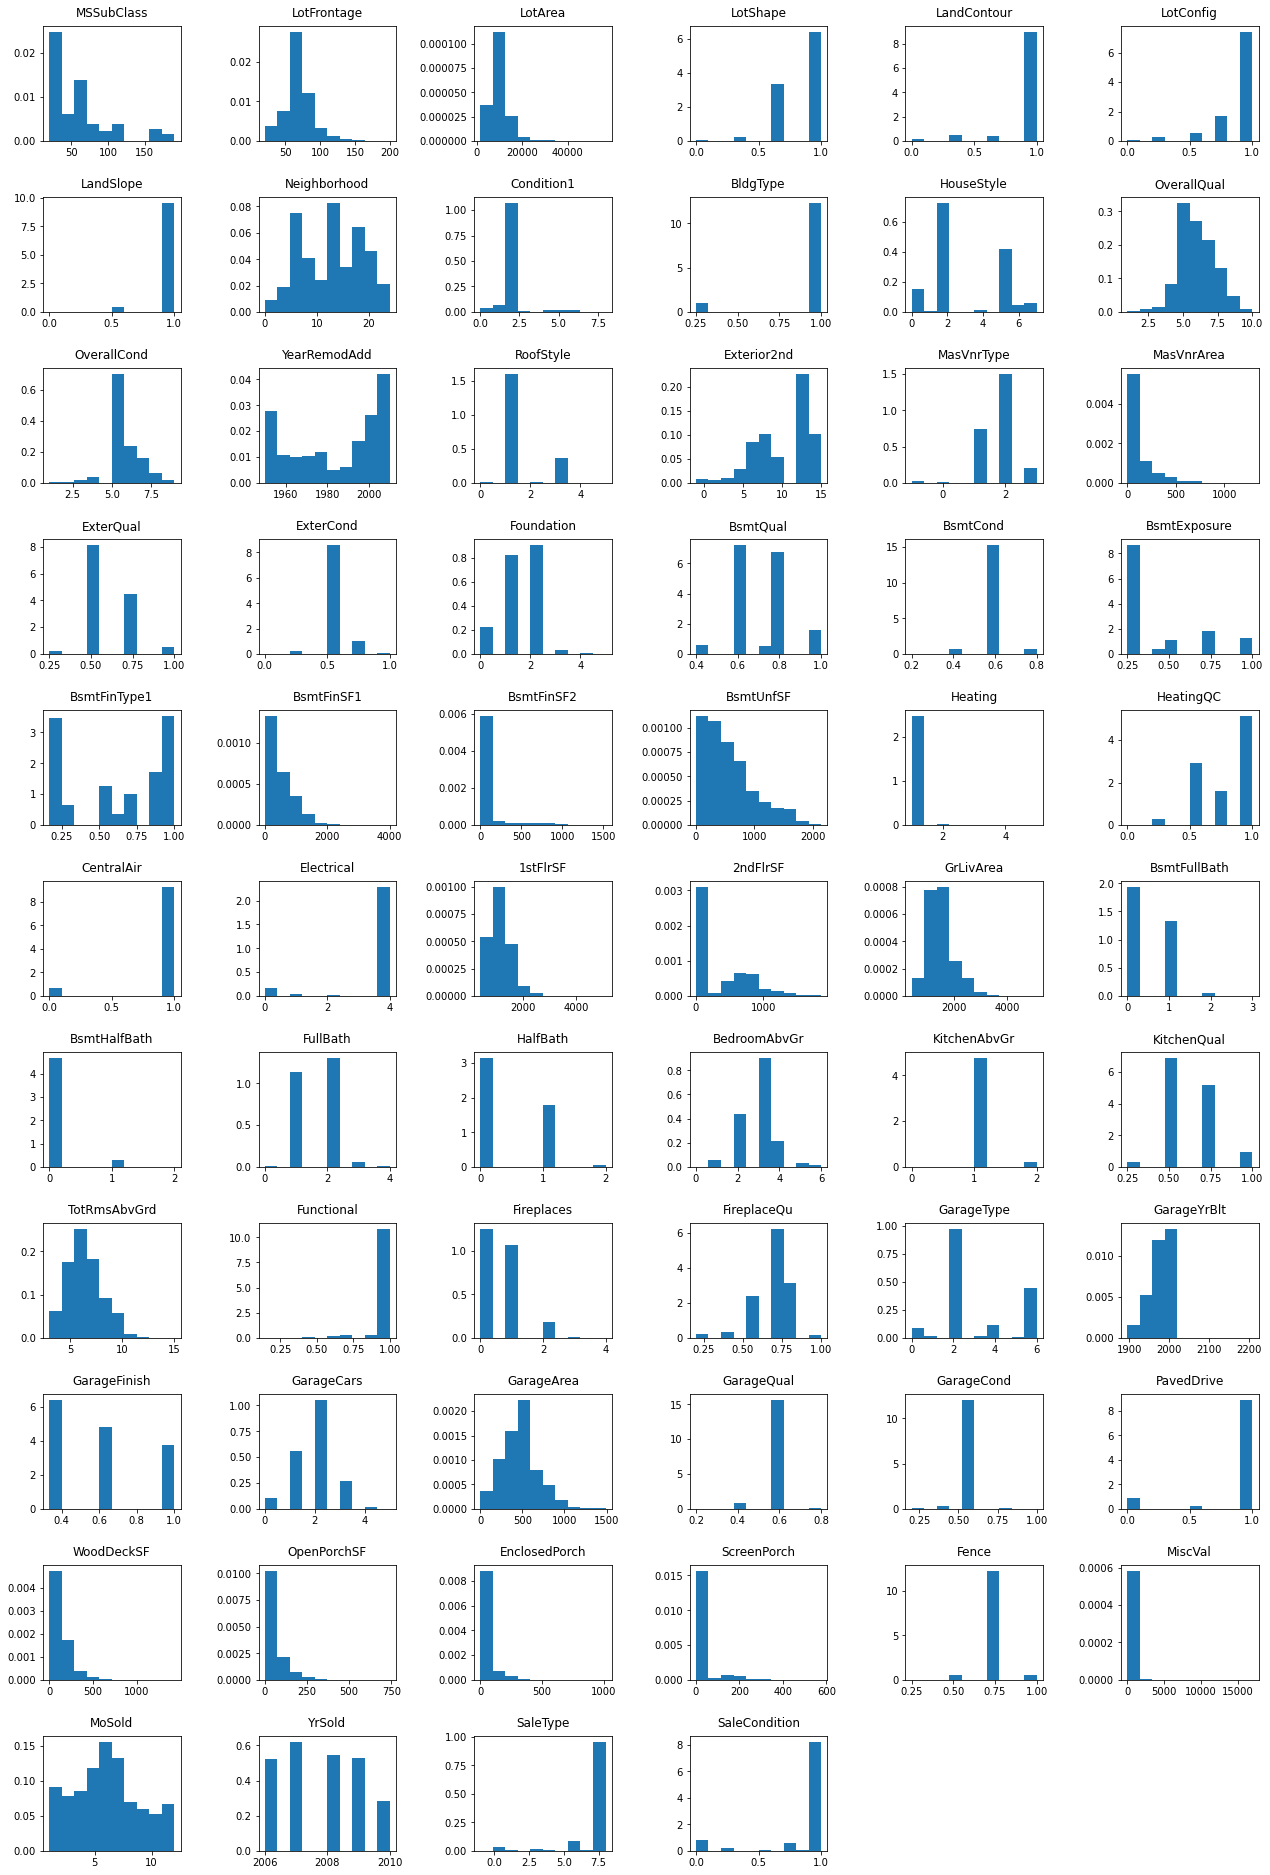

In [10]:
test = clean_test(test_data, factor_map, low_variance_col, columns_to_drop)

print("Test data distribution")
data_dist(test)


In [11]:
# basically I want to clean outliers and find 
# col; where most samples have the same values




In [12]:
train.head(20)

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60    65.000000     8450  1.000000     1.000000       1.00   
2           20    80.000000     9600  1.000000     1.000000       0.25   
3           60    68.000000    11250  0.666667     1.000000       1.00   
4           70    60.000000     9550  0.666667     1.000000       0.75   
5           60    84.000000    14260  0.666667     1.000000       0.25   
7           20    75.000000    10084  1.000000     1.000000       1.00   
8           60    70.049958    10382  0.666667     1.000000       0.75   
9           50    51.000000     6120  1.000000     1.000000       1.00   
11          20    70.000000    11200  1.000000     1.000000       1.00   
12          60    85.000000    11924  0.666667     1.000000       1.00   
13          20    70.049958    12968  0.333333     1.000000       1.00   
14          20    91.000000    10652  0.666667     1.000000       1.00   
15          20    70.049958    10920  0.666667     1.000000       0.75   
16          45    51.000000     6120  1.000000     1.000000       0.75   
17          20    70.049958    11241  0.666667     1.000000       0.50   
18          90    72.000000    10791  1.000000     1.000000       1.00   
19          20    66.000000    13695  1.000000     1.000000       1.00   
20          20    70.000000     7560  1.000000     1.000000       1.00   
21          60   101.000000    14215  0.666667     1.000000       0.75   
22          45    57.000000     7449  1.000000     0.666667       1.00   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2  1.000000  ...           61   
2         1.0            24           1  1.000000  ...            0   
3         1.0             5           2  1.000000  ...           42   
4         1.0             6           2  1.000000  ...           35   
5         1.0            15           2  1.000000  ...           84   
7         1.0            21           2  1.000000  ...           57   
8         1.0            14           4  1.000000  ...          204   
9         1.0            17           0  1.000000  ...            0   
11        1.0            19           2  1.000000  ...            0   
12        1.0            16           2  1.000000  ...           21   
13        1.0            19           2  1.000000  ...            0   
14        1.0             5           2  1.000000  ...           33   
15        1.0            12           2  1.000000  ...          213   
16        1.0             3           2  1.000000  ...          112   
17        1.0            12           2  1.000000  ...            0   
18        1.0            19           2  0.935907  ...            0   
19        1.0            20           5  1.000000  ...          102   
20        1.0            12           2  1.000000  ...            0   
21        1.0            16           2  1.000000  ...          154   
22        1.0             9           2  1.000000  ...            0   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   
7               0            0  0.734875        0       8    2007         8   
8             228            0  0.734875      350      11    2009         8   
9             205            0  0.734875        0       4    2008         8   
11              0     

**Building a model**

steps:
1. Split training set to train and validation-  we evaluate our model based on training set only 
2. Try few types of models and evaluate there "basic" performence
3. Go with the best 1-2 models types and do Hyper-params tuning based on the validation set
4. Evaluate models- develop matricws that can tell about the performence for that specific task- like confusion matrix for defined price classes --> custom loss

Questions/wonders I have-
1. We do not have the test labels- so should we evaluate our performence based on the validation set? Or do we want aslo to keep a " labeled test set" on the side?



In [13]:
train.head()

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60         65.0     8450  1.000000          1.0       1.00   
2           20         80.0     9600  1.000000          1.0       0.25   
3           60         68.0    11250  0.666667          1.0       1.00   
4           70         60.0     9550  0.666667          1.0       0.75   
5           60         84.0    14260  0.666667          1.0       0.25   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2       1.0  ...           61   
2         1.0            24           1       1.0  ...            0   
3         1.0             5           2       1.0  ...           42   
4         1.0             6           2       1.0  ...           35   
5         1.0            15           2       1.0  ...           84   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   

    SaleCondition  SalePrice  
Id                            
1            1.00     208500  
2            1.00     181500  
3            1.00     223500  
4            0.75     140000  
5            1.00     250000  

[5 rows x 65 columns]

In [14]:
min(train["SalePrice"])// 1000 * 1000

35000

In [15]:
def label_hist(df, label, factor):
    label_min=min(train["SalePrice"])// factor * factor
    label_max=factor + max(train["SalePrice"])// factor * factor
    bins=np.arange(label_min, label_max+1, 20 * factor)
    count, _ = np.histogram(df[label], bins=bins)
    fig, ax = plt.subplots(1, 1)
    ax.hist(df[label], bins=bins, edgecolor='white')
    # ax.grid()
    ax.set_title("Label Distribution", fontsize=18)
    ax.set_xlabel(label, fontsize=16)
    ax.set_ylabel("Counts", fontsize=16)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins.astype(int), rotation=90)


    rects = ax.patches
    labels = ["%d" % count[i] for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
                ha='center', va='bottom')

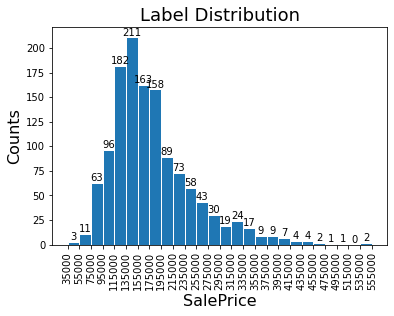

In [16]:
label_hist(train, "SalePrice", 1000)

We can see that the prices distributed like a skewed left normal distribution. We are suspecting that the very high prices will be harder for prediction becuase there are realy few of these.

In [134]:
#Train-test split
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split

y = train.SalePrice
X = train.drop(columns=["SalePrice"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=43)  #split and keep similar y dist.

In [135]:
# Models we want to "test":
# Linear Regression
from sklearn.linear_model import LinearRegression

# LGBM Regressor
from lightgbm import LGBMRegressor

# XGBoost Regressor
from xgboost.sklearn import XGBRegressor

# CatBoost Regressor
from catboost import CatBoostRegressor

# Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor

# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge

# Elastic Net Regression
from sklearn.linear_model import ElasticNet

# Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge

# Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

LinearRegression model MAE= 17481.68466996943
LGBMRegressor model MAE= 15922.55429122519
XGBRegressor model MAE= 17124.83344523112
CatBoostRegressor model MAE= 14816.936501658658
SGDRegressor model MAE= 17725.43444725079
ElasticNet model MAE= 18148.075752762208
BayesianRidge model MAE= 17341.716529684254
GradientBoostingRegressor model MAE= 15939.19722530581
SVR model MAE= 52421.338708494535
LinearRegression model MAE= 17481.684669969432
LGBMRegressor model MAE= 17013.63380031237
XGBRegressor model MAE= 18336.011596679688
CatBoostRegressor model MAE= 16221.744516478144
SGDRegressor model MAE= 17725.43444725081
ElasticNet model MAE= 18148.17346366969
BayesianRidge model MAE= 17341.716529684247
GradientBoostingRegressor model MAE= 16646.695513530776
SVR model MAE= 52421.338708494535


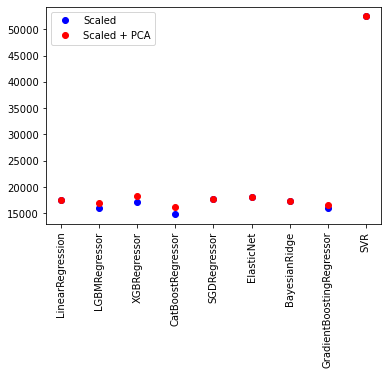

In [136]:
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


models= [LinearRegression(), 
         LGBMRegressor(random_state=43), 
         XGBRegressor(random_state=43), 
         CatBoostRegressor(logging_level='Silent', random_state=43), 
         SGDRegressor(random_state=43), 
         ElasticNet(random_state=43), 
         BayesianRidge(), 
         GradientBoostingRegressor(random_state=43), 
         SVR()]
m_names= ["LinearRegression", 
          "LGBMRegressor", 
          "XGBRegressor", 
          "CatBoostRegressor", 
          "SGDRegressor", 
          "ElasticNet", 
          "BayesianRidge", 
          "GradientBoostingRegressor", 
          "SVR"]

performance=[]
for model, name in zip(models, m_names):
    model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", model)])
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    mae= mean_absolute_error(y_pred, y_val)
    performance.append(mae)
    print(f"{name} model MAE= {mae}")
    
plt.plot(m_names, performance, "o", color="b", label='Scaled')
# plt.xticks(rotation=90)
# plt.show()

performance=[]
for model, name in zip(models, m_names):
    model = Pipeline(steps=[
        ("stand", StandardScaler()),
        ("preprocessor", PCA()), 
        ("model", model)])
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    mae= mean_absolute_error(y_pred, y_val)
    performance.append(mae)
    print(f"{name} model MAE= {mae}")
    
plt.plot(m_names, performance, "o", color="r", label='Scaled + PCA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

From a short research we can get the impression that the PCA did not improve our performance and that SVR is not a good predictor for this model. 

We would like also to print a calibaration plot to understand better how the prediction worked on the training and the validation set

In [137]:
def calibration_plot(y_train_true, y_train_pred, y_val_true, y_val_pred, model_name):
    x= [min(min(y_train_true),min(y_val_true)), max(max(y_train_true),max(y_val_true))]
    fig = plt.figure(figsize=(18,10)) 
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(y_train_true, y_train_pred, 'o', linewidth=6, color='b')
    ax1.plot(x,x, linewidth=4)
    ax1.set_ylabel("Predicted Price")
    ax1.set_xlabel("True Sale Price")
    ax1.set_title(f'Training set, mae={np.round(mean_absolute_error(y_train_true, y_train_pred), 2)}')

    ax2 = plt.subplot(1,2,2)
    ax2.plot(y_val_true, y_val_pred, 'o', linewidth=6, color='g')#, label="Test set"
    # plt.legend(loc="upper left")
    ax2.plot(x,x, linewidth=4)
    # ax2.plot(np.linspace(8.8+1.83,16.5,5),np.linspace(8.8+1.83,16.5,5)-1.83,'r')
    # ax2.plot(np.linspace(8.8,16.5-1.87),np.linspace(8.8,16.5-1.57)+1.57,'r')
    ax2.set_ylabel("Predicted Price")
    ax2.set_xlabel("True Sale Price")
    ax2.set_title(f'Validation set, mae={np.round(mean_absolute_error(y_val_true, y_val_pred), 2)}')
    fig.suptitle(model_name, fontsize=30)
    plt.show()

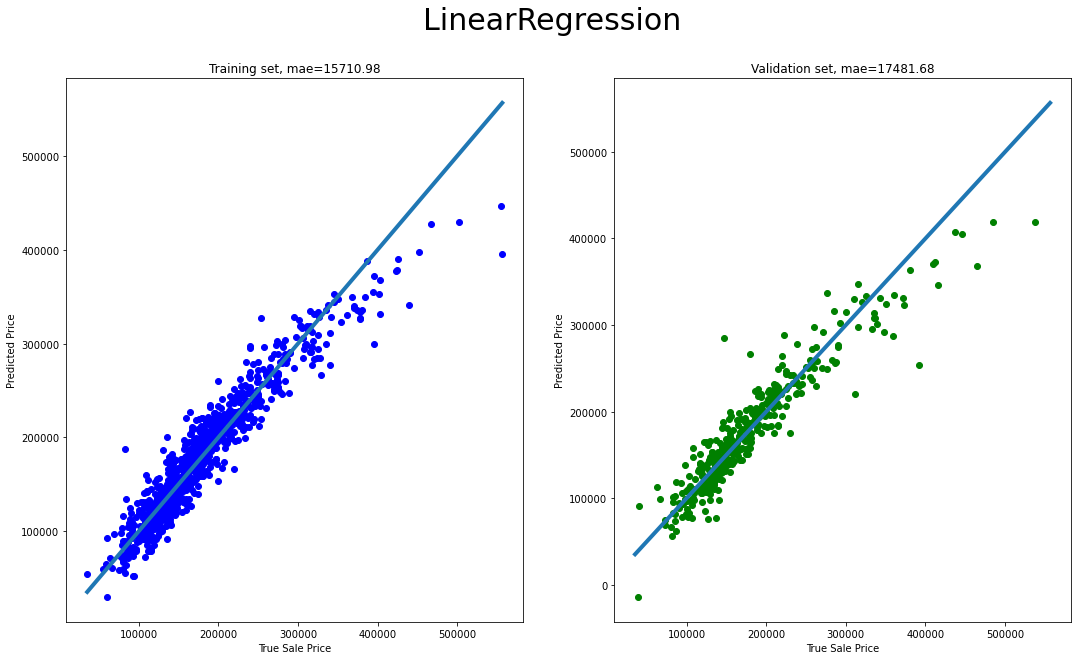

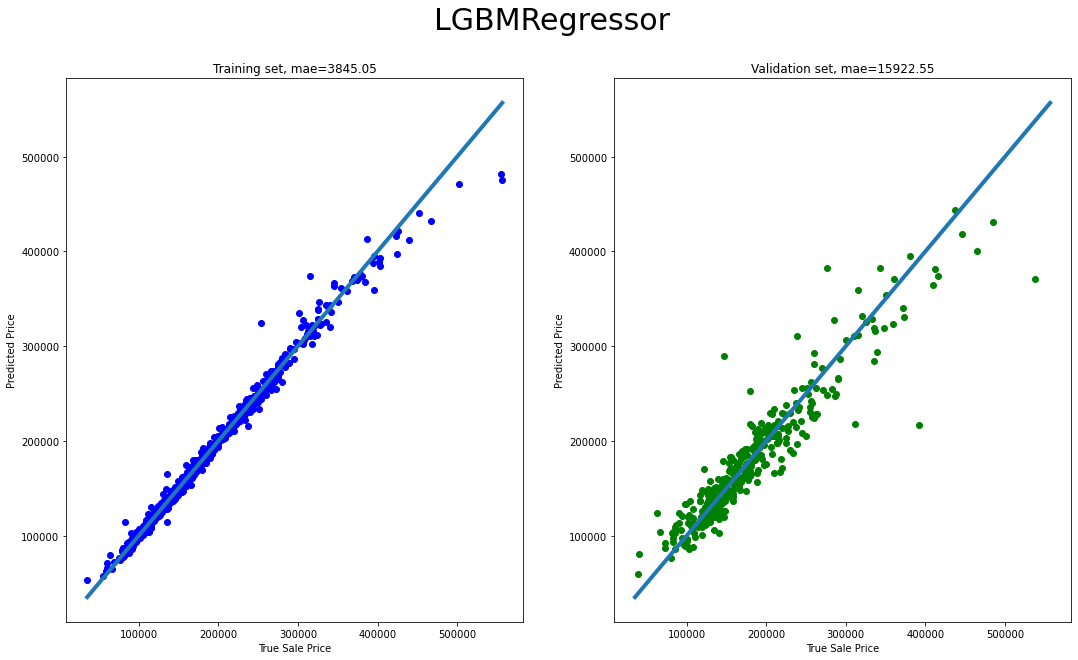

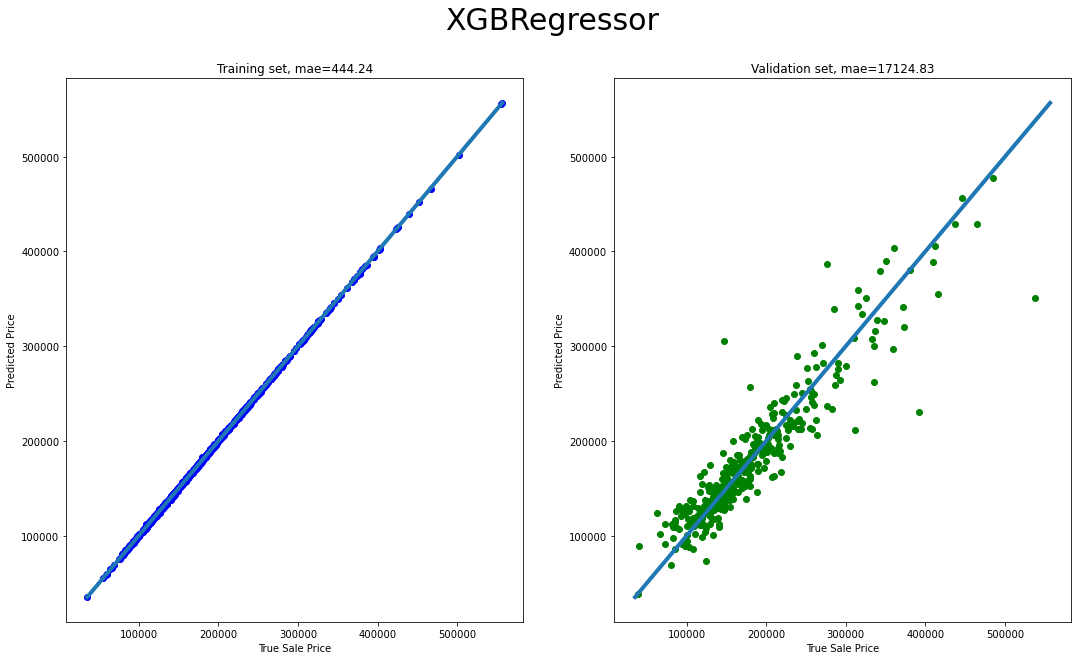

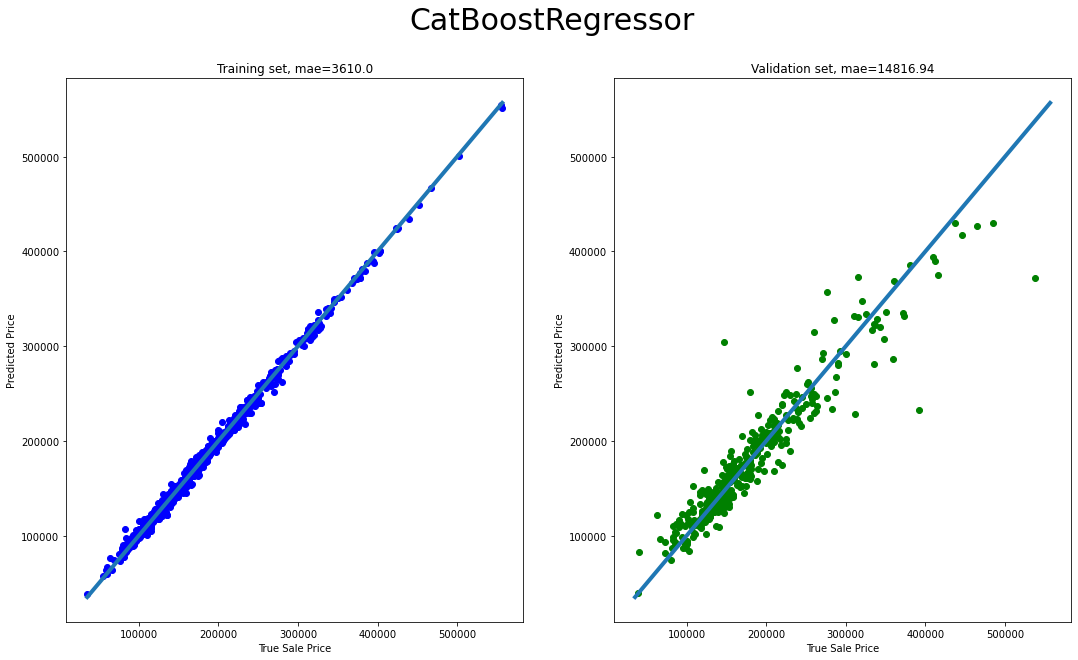

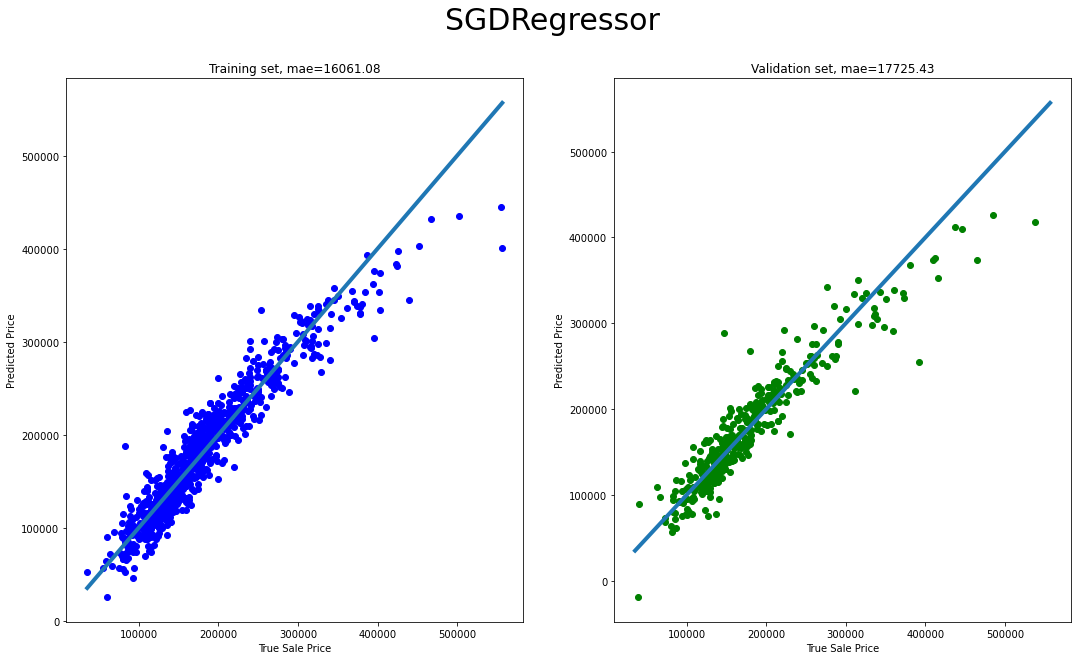

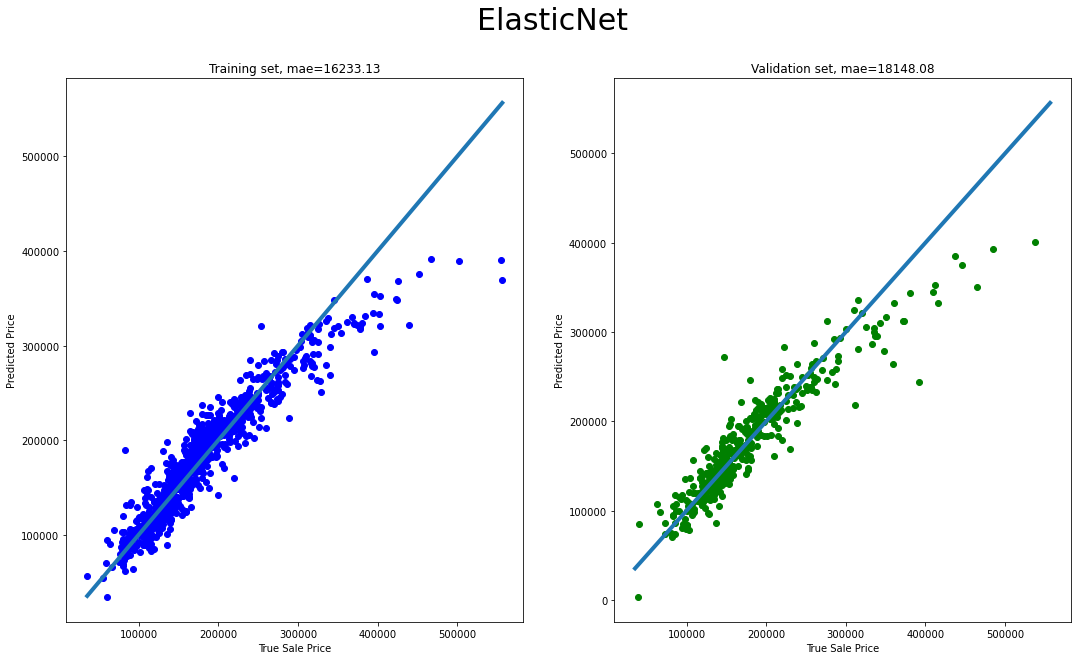

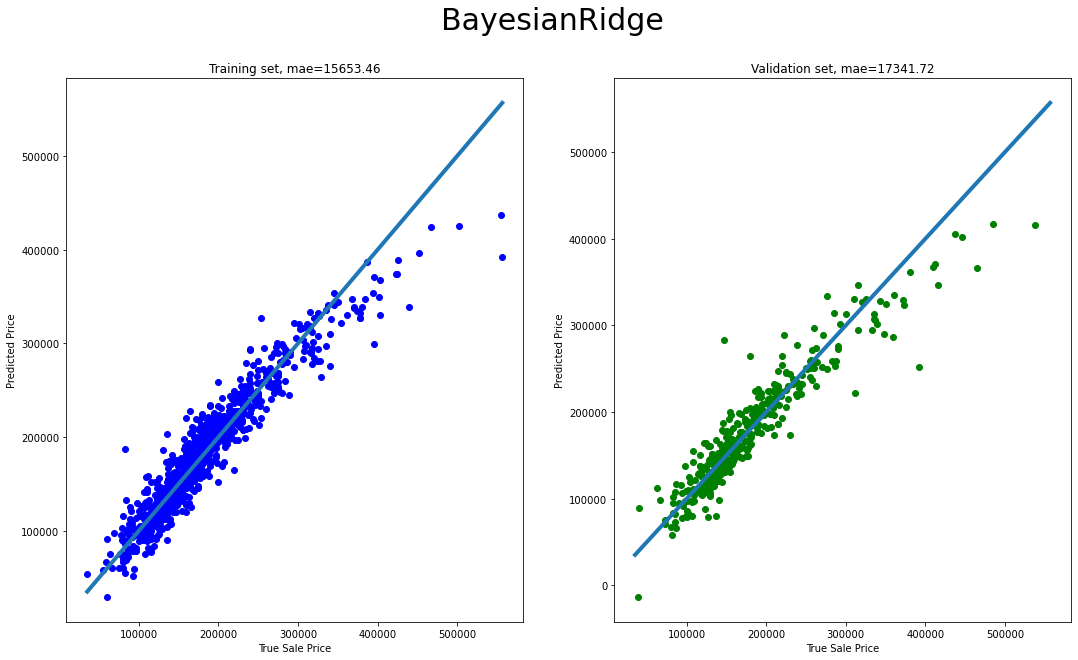

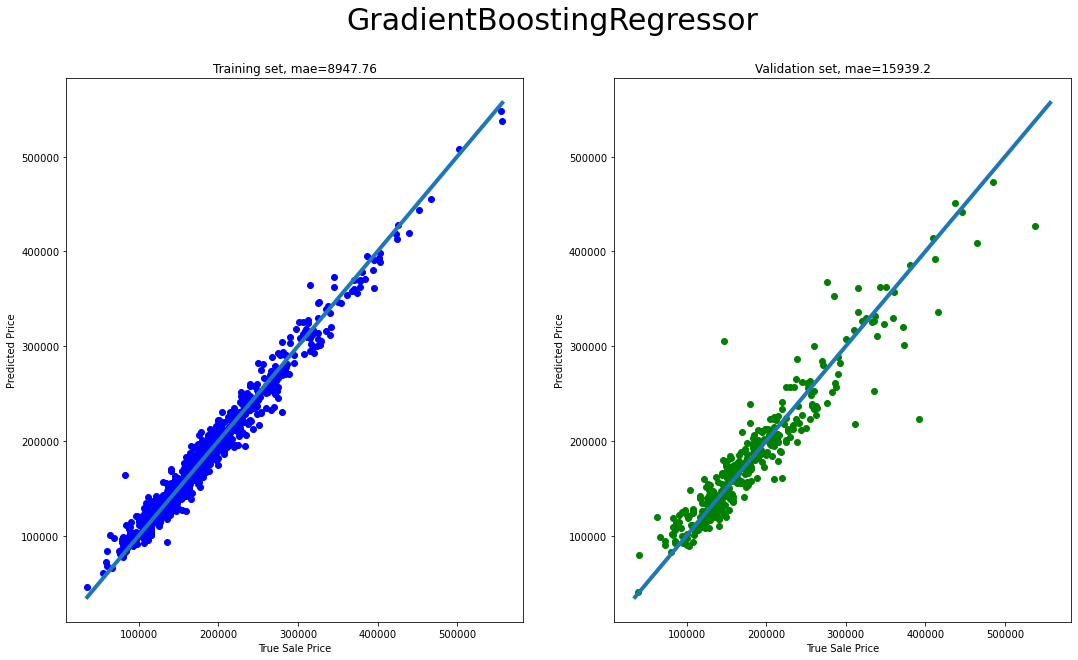

In [138]:
for model, name in zip(models[:-1], m_names[:-1]):
    model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", model)])
    reg = model.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    y_val_pred = reg.predict(X_val)
    calibration_plot(y_train, y_train_pred, y_val, y_val_pred, name)

Understandings from the claibration plots:
* LinearRegression- "simple" model that gave rise to not very bad prediction
* LGBMRegressor- good prediction and a slightly better MAE, but hasing overfit 
* XGBRegressor- highly overfitting, high potential to improve once we reduce overfit
* CatBoostRegressor- similar to XGBRegressor
* SGDRegressor-under estimating the high prices. Might be improved by hyper params tuning
* ElasticNet-similar to SGDRegressor
* BayesianRidge- similar to SGDRegressor
* GradientBoostingRegressor- really good model in terms of not suffer from overfitting and all samples follow the blue line trend


Hence, we would like to have deeper investigation with- **LGBMRegressor, XGBRegressor, CatBoostRegressor**. All of these methods are actually boosting algorithms. To understand better the difference we went over thos article: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

Instaed of having a validation set for hyper paprams tuning, we will use Cross Validation. Also, we played mostly with parameters that restricting the model ability to overfit

In [139]:
# Lets initially scale all X data:

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_val_scaled= scaler.transform(X_val)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/dankontorovskyi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.87322782 0.80225949 0.90649567 0.90487663        nan 0.63591196
        nan 0.89741289 0.90751236 0.74585404 0.79687005 0.86916418
        nan 0.90308933        nan        nan        nan        nan
 0.91209754 0.9013598  0.83904181        nan 0.88157037        nan
        nan 0.90461086 0.91559607 0.89911195        nan 0.91445885
        nan        nan        nan 0.90336348 0.85941431        nan
 0.90254377 0.91231378        nan        nan 0.89941568        nan
 0.77065251 0.76618018 0.51938718        nan 0.90996717        nan
 0.91442924 0.78925525        nan 0.87312367 0.80616396 0.85964387
 0.90718118 0.80786183 0.87175185        nan 0.77380866        nan
 0.91420237 0.8938382  0.66045355 0.73062337 0.89673068        nan
 0.74582294 0.90369534 0.91506135 0.90765278        nan        nan
        nan        nan        n

best score= 0.9161067236544624
{'subsample': 0.5, 'reg_lambda': 5, 'reg_alpha': 100, 'n_estimators': 300, 'metric': 'mae', 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 15, 'feature_fraction': 0.75, 'colsample_bytree': 0.5, 'bagging_fraction': 0.25}


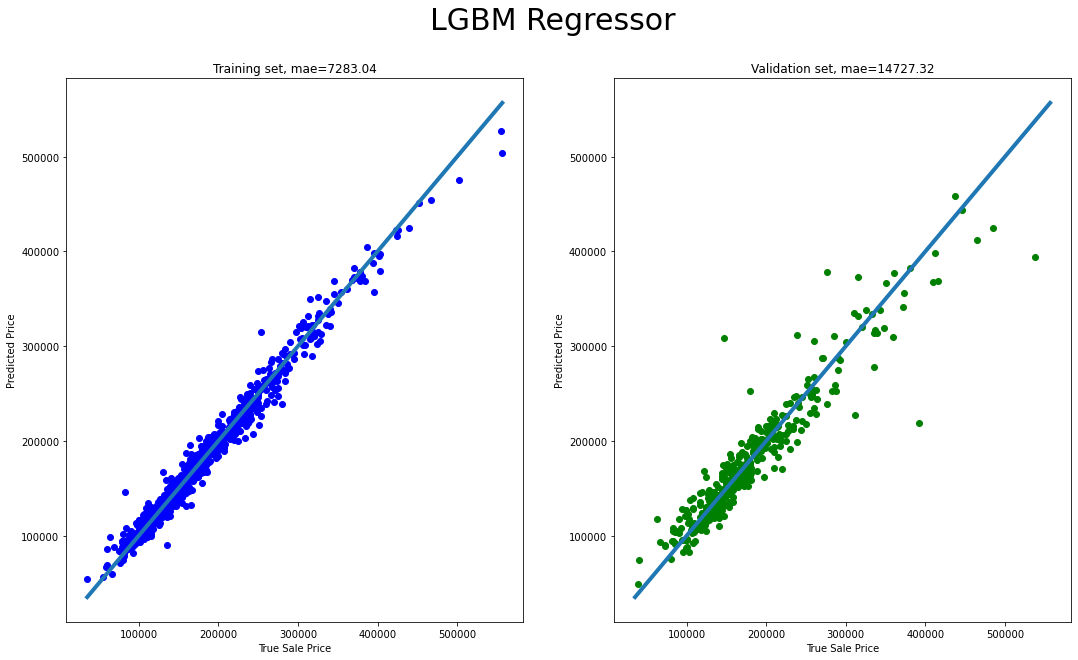

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[17:18:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { bagging_fraction, feature_fraction, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


best score= 0.9176600827561977
{'subsample': 0.5, 'reg_lambda': 5, 'reg_alpha': 100, 'n_estimators': 300, 'metric': 'mae', 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 10, 'feature_fraction': 1, 'colsample_bytree': 0.5, 'bagging_fraction': 0.5}


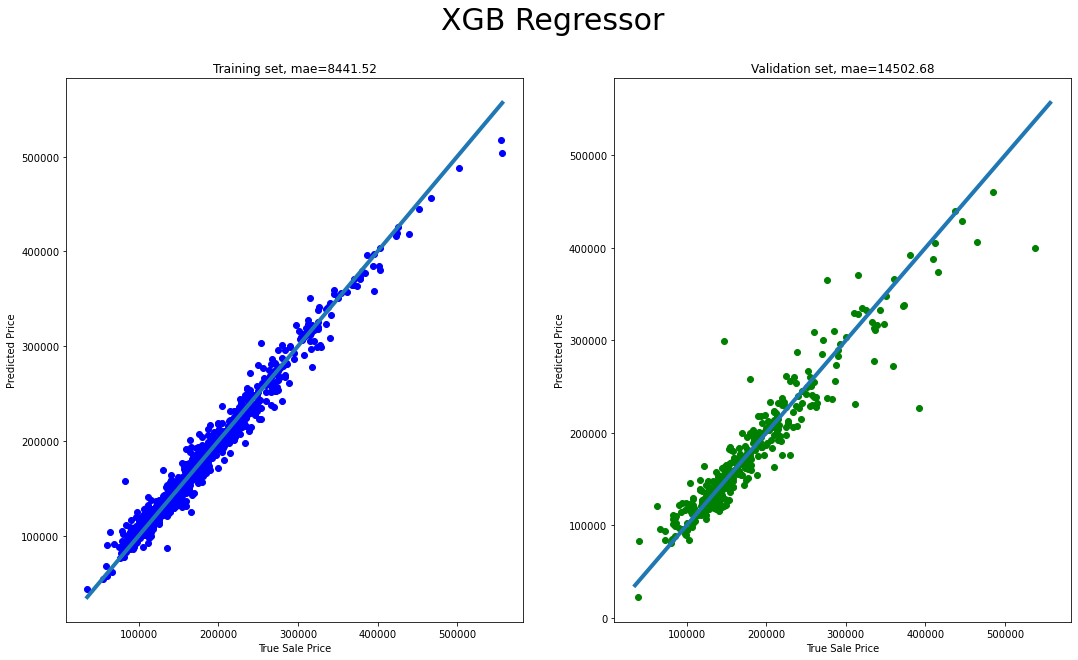

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
best score= 0.9169463733662264
{'subsample': 0.5, 'reg_lambda': 10, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}


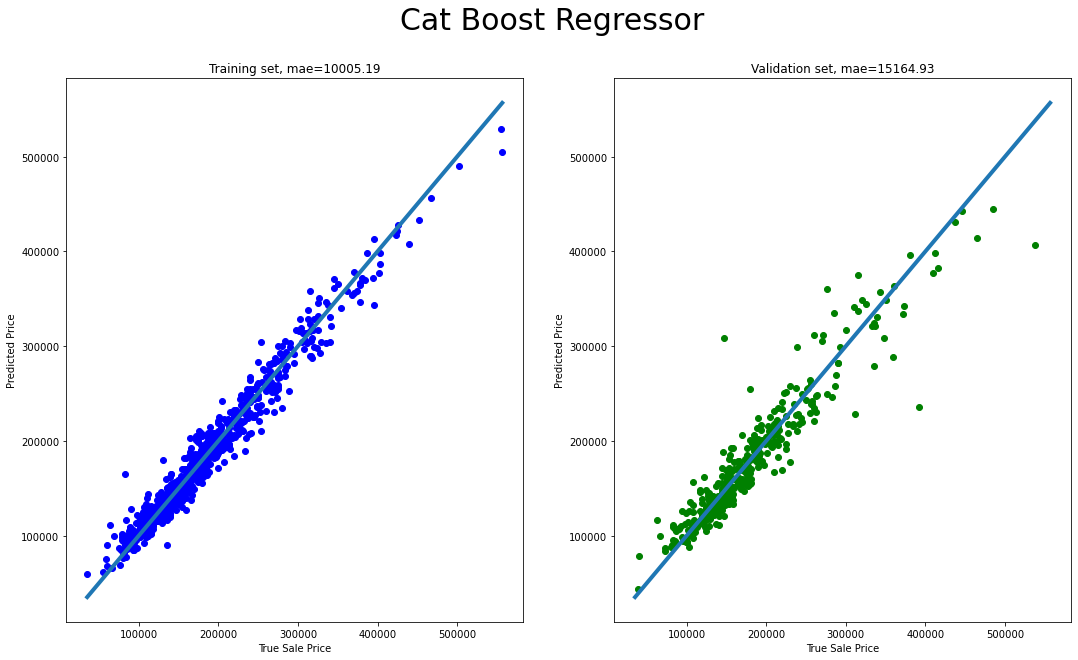

In [140]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

models = [LGBMRegressor(random_state=43), 
          XGBRegressor(random_state=43), 
          CatBoostRegressor(random_state=43, logging_level='Silent')]
m_names = ["LGBM Regressor", 
           "XGB Regressor", 
           "Cat Boost Regressor"]

gridParams_a = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 7, 8],
    'colsample_bytree' : [0.5, 0.7],
    'subsample' : [0.5, 0.7],
    'metric':['mse', 'mae'],
    'reg_lambda':[5, 10, 30, 60, 100, 125],
    'reg_alpha':[5, 10, 30, 60, 100, 125],
    'gamma': [0, 5, 10, 15],
    'bagging_fraction': [0, 0.25, 0.5, 0.75, 1], 
    'feature_fraction': [0, 0.25, 0.5, 0.75, 1]
    }

gridParams_b = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 7, 8],
    'subsample' : [0.5, 0.7],
    'reg_lambda':[5, 10, 30, 60, 100, 125]
    }

best_params=[]
best_models=[]

for clf, name, gridParams  in zip(models, m_names, [gridParams_a, gridParams_a, gridParams_b]):
    grid = RandomizedSearchCV(clf, gridParams, verbose=1, cv=5, n_jobs = -1, n_iter=200, random_state=43)
    grid.fit(X_train_scaled,y_train)
    model = grid.best_estimator_
    print("best score=", grid.best_score_)
    print(grid.best_params_)
    best_params.append(grid.best_params_)
    best_models.append(grid.best_estimator_)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    calibration_plot(y_train, y_train_pred, y_val, y_val_pred, name)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/dankontorovskyi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.87322782 0.80225949 0.90649567 0.90487663        nan 0.63591196
        nan 0.89741289 0.90751236 0.74585404 0.79687005 0.86916418
        nan 0.90308933        nan        nan        nan        nan
 0.91209754 0.9013598  0.83904181        nan 0.88157037        nan
        nan 0.90461086 0.91559607 0.89911195        nan 0.91445885
        nan        nan        nan 0.90336348 0.85941431        nan
 0.90254377 0.91231378        nan        nan 0.89941568        nan
 0.77065251 0.76618018 0.51938718        nan 0.90996717        nan
 0.91442924 0.78925525        nan 0.87312367 0.80616396 0.85964387
 0.90718118 0.80786183 0.87175185        nan 0.77380866        nan
 0.91420237 0.8938382  0.66045355 0.73062337 0.89673068        nan
 0.74582294 0.90369534 0.91506135 0.90765278        nan        nan
        nan        nan        n

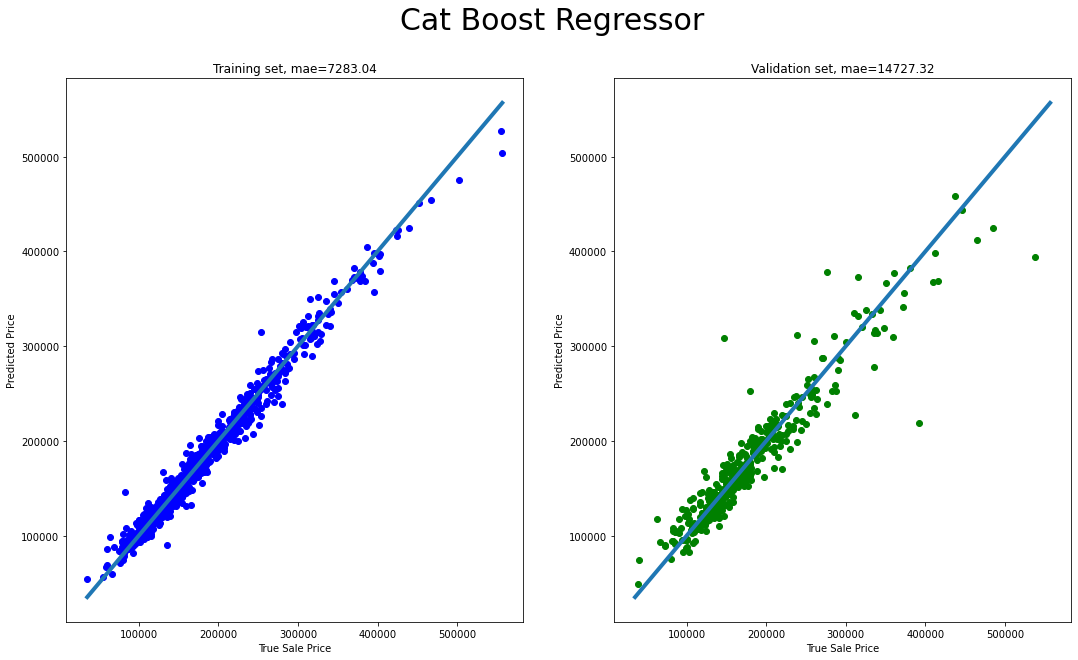

In [141]:
best_models=[]

grid = RandomizedSearchCV(LGBMRegressor(random_state=43), gridParams_a, verbose=1, cv=5, n_jobs = -1, n_iter=200, random_state=43)
grid.fit(X_train_scaled,y_train)
model = grid.best_estimator_
best_models.append(grid.best_estimator_)
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
calibration_plot(y_train, y_train_pred, y_val, y_val_pred, name)


Due to the performence, and the model behavior, we woould like to leep the LGBM Regressor as our model!

In [142]:
reg= best_models[0]
y_pred_train = reg.predict(X_train_scaled)
y_pred_val = reg.predict(X_val_scaled)

In [143]:
# calibration_plot(y_train, y_pred_train, y_val, y_pred_val, "LGBM Regressor")

In [144]:
def bland_altman_plot(y_true, y_pred, figure = True):
    loa_95=1.95
    loa_75=1.75
    loa_50=1.50
    y_true= np.asarray(y_true)
    y_pred= np.asarray(y_pred)
    diff= y_true - y_pred  # Difference between data1 and data2
    mean = np.mean([y_true, y_pred], axis=0)
    md = np.mean(diff)  # Mean of the difference
    mae = np.mean(abs(diff)) # Mean of the difference
    sd = np.std(diff, axis=0)
    
    # Standard deviation of the difference
    print("sd_high_95= ", (md + loa_95*sd), "sd_low_95= ", (md + loa_95*sd))
    print("sd_high_75= ", (md + loa_75*sd), "sd_low_75= ", (md + loa_75*sd))
    print("sd_high_50= ", (md + loa_50*sd), "sd_low_50= ", (md + loa_50*sd))

    sd_mean_95= ((md + loa_95*sd)-(md - loa_95*sd))/2
    sd_mean_75= ((md + loa_75*sd)-(md - loa_75*sd))/2
    sd_mean_50= ((md + loa_50*sd)-(md - loa_50*sd))/2

    if figure:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(mean, diff)
        m, b = np.polyfit(y_true,diff, 1)
        ax.axhline(md, color='gray', linestyle='--')
        ax.axhline(md + loa_95*sd, color='gray', linestyle='--')
        ax.axhline(md - loa_95*sd, color='gray', linestyle='--')
        ax.set_ylabel("Error (g/dL)")
        ax.set_xlabel("Mean Price")
        ax.set_title(f"Bland-Altman plot- test set\nLimits of Agreement 95%={np.round(sd_mean_95,3)}g/dL") #\n% of sample with error less than one: {np.round(count_correct_tag(y_true, y_pred, 1),2)}
        plt.tight_layout()
    plt.show()

Since the behaviour and the performence of the model in the edges is very important, we would like to check also the Bland-Altman plot- that can teach us how sparse are the prediction, and also measure it by the LOIA (levels of agreement) values: 

sd_high_95=  20018.97203242702 sd_low_95=  20018.97203242702
sd_high_75=  17964.82514947766 sd_low_75=  17964.82514947766
sd_high_50=  15397.141545790955 sd_low_50=  15397.141545790955


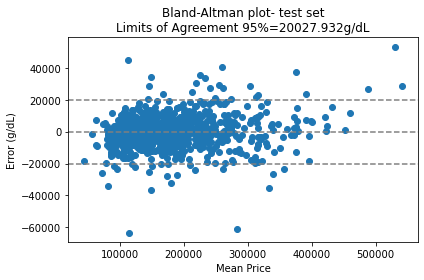

In [145]:
# Bland-Altman plot for training set
bland_altman_plot(y_train, y_pred_train)

sd_high_95=  46687.63467130816 sd_low_95=  46687.63467130816
sd_high_75=  41972.66695748903 sd_low_75=  41972.66695748903
sd_high_50=  36078.95731521512 sd_low_50=  36078.95731521512


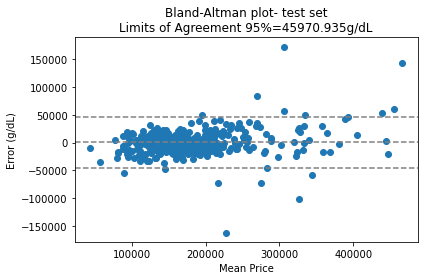

In [146]:
# Bland-Altman plot for validation set
bland_altman_plot(y_val, y_pred_val)

We actually can learn that there is still a gap between the LOA values if we compare the train and validation set. We might think about inhancing nore regularization to the model and avoid overfitting by that.

In [147]:
test_trans = scaler.transform(test)
res = reg.predict(test_trans)

In [148]:
test_copy = test.copy()
test_copy = test_copy.drop(columns = test_copy.columns)
test_copy['Predicted'] = res

In [149]:
test_copy.to_csv('submission_v1.csv')



In [150]:
test_copy.describe()

Predicted
count    1459.000000
mean   178937.398350
std     75006.394095
min     45188.374163
25%    128206.596887
50%    160037.258965
75%    209335.399901
max    518159.427243